In [9]:
#rm(list=ls())
library(magrittr)
library(dplyr)
setwd("/home/huaqingj/MyResearch/HistTrial")
#setwd("C:/Users/JINHU/Documents/ProjectCode/HistTrial")
source("utils.R")
library(parallel)

In [10]:
info.est.fn <- function(Theta0s, data, H, lam, is.borrow=TRUE, maxit=100){
    #args:
    #  Theta0s: Estimated ys based on historical data
    #  data: the dataset, n x (2+p): [Y, Z, Xs]
    #  H: cov mat, p x p
    #  lam: The penalty parameters
    #  is.borrow: if true, borrows from Theta0s, otherwise, no borrowing
    #  maxit: Maximal number of times for iteration
    
    phi0.tk <- c()
    Mu0s.tk <- list()
    Tau2s.tk <- list()
    Xs <- data[, 3:6]
    n <- dim(Xs)[1]
    phi0 <- 0.5
    Tau2s <- rep(0, n)
    
    for (i in 1:maxit){
        Mu0s <- mOptMu0(as.matrix(Xs), data, Tau2s, phi0, Theta0s, H)
        Mu0s.tk[[i]] <- Mu0s
        
        if (is.borrow){
            Tau2s  <- mOptTau(as.matrix(Xs), data, Mu0s, lam, Theta0s, H)
        }
        Tau2s.tk[[i]] <- Tau2s
        
        #res <- optPhi(data, Mu0s)
        #phi0 <- res$root
        phi0.tk <- c(phi0.tk, phi0)
        
        if (i > 1){
            err.tau2 <- sum((Tau2s.tk[[i]] - Tau2s.tk[[i-1]])**2)
            err.mu <- sum((Mu0s.tk[[i]] - Mu0s.tk[[i-1]])**2)
            err.phi <- (phi0.tk[i] - phi0.tk[i-1])**2
            
            err.all <- max(c(err.tau2, err.mu, err.phi))
            if (err.all < 1e-5){
                break
            }
        }
        
    }
    
    res <- list(tau2s=Tau2s, mu0s=Mu0s, phi0=phi0, mu0tk=Mu0s.tk, phi0tk=phi0.tk, tau2stk=Tau2s.tk,
                theta0s=Theta0s, H=H, data=data, lam=lam)
    res
}

In [11]:
fun <- function(i){
    print(i)
    Xs <- gen.Data.Xs(n0, x.tps)
    idx0 <- sample.int(n0, size=floor(n0/2))
    Zs <- rep(1, n0)
    Zs[idx0] <- 0
    
    
    betMat <- sub.Paras.fn(Xs, betass)
    nerrs <- rnorm(n0, sd=phi0)
    Ys <- curMean.fn(Xs, Zs, betMat, b) + nerrs
    data <- cbind(Ys, Zs, Xs)
    data <- as.data.frame(data)
    colnames(data)[1:2] <- c("Y", "Z")
    
    
    # no borrowing 
    Zs.no <- Zs
    Ys.no <- curMean.fn(Xs, Zs.no, betMat, b) + nerrs
    data.no <- cbind(Ys.no, Zs.no, Xs)
    data.no <- as.data.frame(data.no)
    colnames(data)[1:2] <- c("Y", "Z")
    
    for (j in (n0+1):N){
        cx <- unlist(gen.Data.Xs(1, x.tps))
        
        # H <- diag(c(bw.nrd(data$X1), bw.nrd(data$X2), bw.nrd(data$X3), bw.nrd(data$X4)))
        alpMat <- sub.Paras.fn(Xs, alpss)
        Theta0s <- curMean.fn(Xs, Zs, alpMat, b=0)
        res <- info.est.fn(Theta0s, data, H, lam)
        res0 <- info.est.fn(Theta0s, data, H, lam, is.borrow=FALSE)
        
        var.info <- post.var.mu0.fn(cx, res)
        var.ref <- post.var.mu0.fn(cx, res0)
        R <- var.ref/var.info
        ass.res <- RPS.design(cx, data[, 3:6], data$Z, hs, R)
        ass.res.no <- RPS.design(cx, data[, 3:6], data.no$Z, hs, R=1)
        # ass.res <- RBC.design(cx, data[, 3:6], data$Z, hs, R)
        
        Xs <- rbind(Xs, cx)
        Zs <- c(Zs, ass.res$grp-1)
        Zs.no <- c(Zs.no, ass.res.no$grp-1)
        
        curN <- dim(Xs)[1]
        curBetMat <- sub.Paras.fn(Xs[curN, ], betass)
        nerr <- rnorm(1, sd=phi0)
        Y <- curMean.fn(Xs[curN, ], Zs[curN], curBetMat, b) + nerr
        Ys <- c(Ys, Y)
        data <- cbind(Ys, Zs, Xs)
        data <- as.data.frame(data)
        colnames(data)[1:2] <- c("Y", "Z")
        
        Y.no <- curMean.fn(Xs[curN, ], Zs.no[curN], curBetMat, b) + nerr
        Ys.no <- c(Ys.no, Y.no)
        data.no <- cbind(Ys.no, Zs.no, Xs)
        data.no <- as.data.frame(data.no)
        colnames(data.no)[1:2] <- c("Y", "Z")
        
        
        if (j==N){
            #H <- diag(c(bw.nrd(data$X1), bw.nrd(data$X2), bw.nrd(data$X3), bw.nrd(data$X4)))
            alpMat <- sub.Paras.fn(Xs, alpss)
            Theta0s <- curMean.fn(Xs, Zs, alpMat, b=0)
            res <- info.est.fn(Theta0s, data, H, lam)
            res.no <- info.est.fn(Theta0s, data.no, H, lam, is.borrow=FALSE)
        }
    }
    
    
    res.mu1 <- mu1.est.fn(data$Y, data, H)
    res.no.mu1 <- mu1.est.fn(data.no$Y, data.no, H)
    trt.eff <- mean(mu1.efn(as.matrix(Xs), res.mu1)) -  mean(mu0.efn(as.matrix(Xs), res));trt.eff
    trt.eff.no <- mean(mu1.efn(as.matrix(Xs), res.no.mu1)) -  mean(mu0.efn(as.matrix(Xs), res.no));trt.eff.no
    c(trt.eff, trt.eff.no)
}

In [12]:
# parameters for current data 
betass <- list(
              para1=c(2, 1, -1, 3, -2), 
              para2=c(3, 1, 2, 4, 2), 
              para3=c(0, -1, -1, 3, 2), 
              para4=c(2, 0, -1, 4, -2)
                  )

betass <- list(
              para1=c(2, 1, -1, 3, -2), 
              para2=c(2, 1, -1, 3, -2), 
              para3=c(2, 1, -1, 3, -2), 
              para4=c(2, 1, -1, 3, -2)
                  )
# parameters for historical data
alpss <-  list(para1=c(2, 1, -1, 3, -2), 
             para2=c(3, 1, 2, 4, 2), 
             para3=c(0, -1, -1, 3, 2), # switch para2 and para3
             para4=c(2, 0, -1, 4, -2) )
alpss <- betass
b <- 2
phi0 = phi1 = 0.5
N <- 100 # total sample size
# parameters
lam <- 0.05
hs <- rep(2.1, 4)
x.tps <- c(2, 2, "c", "c")

tXs <- gen.Data.Xs(1000, x.tps)
H <- diag(c(bw.nrd(tXs[, 1]), bw.nrd(tXs[, 2]), bw.nrd(tXs[, 3]), bw.nrd(tXs[, 4])))
#H <- diag(c(0.1, 0.1, 0.1, 0.1))

# initial dataset
n0 <- 20

In [13]:
nSimu <- 100
trt.effs <- mclapply(1:nSimu, fun, mc.cores=6)

idxs <- sapply(1:nSimu, function(i){is.vector(trt.effs[[i]])})
trt.effs <- trt.effs[idxs]

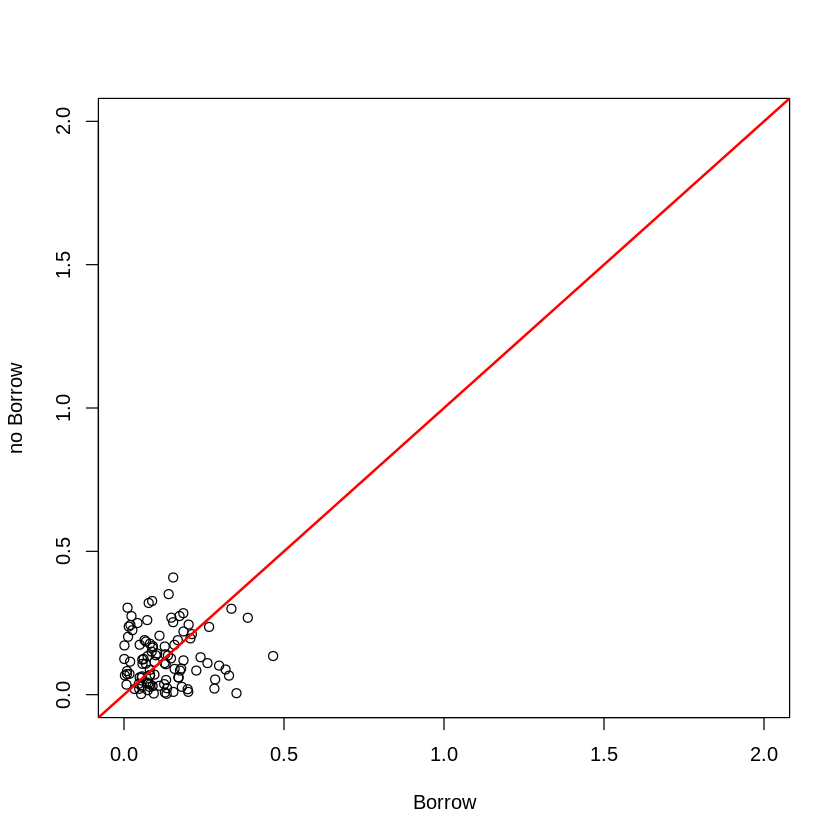

In [14]:
trt.effs.mat <- do.call(rbind, trt.effs)
errs <- abs(trt.effs.mat - b)
plot(errs[, 1], errs[, 2], xlim=c(0, 2), ylim=c(0, 2), ylab="no Borrow", xlab="Borrow")
abline(a=0, b=1, col=2, lwd=2)

In [15]:
m.err <- colMeans(errs)
names(m.err) <- c("Borrow", "no Borrow")
m.err
err.se1 <- sd(errs[, 1])/sqrt(length(errs[, 1]))
err.se2 <- sd(errs[, 2])/sqrt(length(errs[, 2]))
err.CI <- c(m.err[1]-1.96*err.se1, m.err[1], m.err[1]+1.96*err.se2)
err.CI.no <- c(m.err[2]-1.96*err.se1, m.err[2], m.err[2]+1.96*err.se2)
CIs <- rbind(err.CI, err.CI.no)
colnames(CIs) <- c("Low", "Mean", "Up")
rownames(CIs) <- c("Borrow", "No Borrow")
CIs

Borrow no Borrow 
0.1247375 0.1275480

,Low,Mean,Up
Borrow,0.1064302,0.1247375,0.1432455
No Borrow,0.1092407,0.1275480,0.1460561
